In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import *
from data import *
import math

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader as DL
import torch.nn.functional as F
import torch.nn.init as init
torch.cuda.empty_cache()

In [36]:
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

Using CUDA


In [4]:
data_f = './'
# train_path = data_f + 'DIV2K/DIV2K_valid_HR/'
train_path = data_f + 'Images/'
test__path = data_f + 'Test/Set5/'

In [5]:
train_set = DataSetF(train_path,2) ## input Image folder and scale
test_set =  DataSetF(test__path,2)

In [6]:
train_loader = DL(train_set) ## input Image folder and scale
test_loader =  DL(test_set)

In [7]:
data=iter(train_loader)
data=data.next()
data[0].size(),data[1].size()
# data[0].size()

(torch.Size([1, 1, 16, 16]), torch.Size([1, 1, 32, 32]))

In [8]:
## UTILITY FUNCTIONS
def Test_with_psnr(model):
    avg_psnr = 0
    for batch in test_loader:
        img,label = batch[0].to(device),batch[1].to(device)
        out = model(img)
        psnr = PSNR(out,label)
        avg_psnr += psnr
    print("Avg. PSNR :",{avg_psnr / len(test_loader)}, "dB.")
    return avg_psnr / len(test_loader)
    
def PSNR(imageTensor,labelTensor):
    criterion = nn.MSELoss()
    loss = criterion(imageTensor,labelTensor)
    psnr = 10*math.log10(1/loss.item())
    return psnr
def PSNR_img(image,label):
    assert image.size==label.size
    tensor = transforms.ToTensor()
    imageTensor = tensor(image)
    labelTensor = tensor(label)
    return PSNR(imageTensor,labelTensor)

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1,64,kernel_size = 9,padding = 4)
        self.conv_layer2 = nn.Conv2d(64,32,kernel_size = 1,padding = 0)
        self.conv_layer3 = nn.Conv2d(32,1,kernel_size = 5,padding = 2)
        
#     def forward_feed(self,x):
    def __call__(self,x):
        out = F.relu(self.conv_layer1(x))
        out = F.relu(self.conv_layer2(out))
        out = self.conv_layer3(out)
        return out

In FSRCNN, 5 main steps as in the figure with more convolutions are involved:

    1.Feature Extraction: Bicubic interpolation in previous SRCNN is replaced by 5×5 conv.
    2.Shrinking: 1×1 conv is done to reduce the number of feature maps from d to s where s<<d.
    3.Non-Linear Mapping: Multiple 3×3 layers are to replace a single wide one
    4.Expanding: 1×1 conv is done to increase the number of feature maps from s to d.
    5.Deconvolution: 9×9 filters are used to reconstruct the HR image.

In [9]:
class FSRCNN(nn.Module):
    def __init__(self,upscale_factor):
        super(FSRCNN, self).__init__()
        # Feature extraction
        self.feature_extraction = nn.Sequential(
                      nn.Conv2d(1, 56, (5, 5), (1, 1), (2, 2)),
                      nn.PReLU(56)
                      )
        # Shrinking
        self.shrink = nn.Sequential(
                      nn.Conv2d(56, 12, (1, 1), (1, 1), (0, 0)),
                      nn.PReLU(12)
                      )
        
        # Mapping layer.
        self.map = nn.Sequential(
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12),
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12),
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12),
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12)
                      )

        # Expanding layer.
        self.expand = nn.Sequential(
                      nn.Conv2d(12, 56, (1, 1), (1, 1), (0, 0)),
                      nn.PReLU(56)
                      )

        # Deconvolution layer.
        self.deconv = nn.ConvTranspose2d(56, 1, (9, 9), (upscale_factor, upscale_factor), (4, 4), (upscale_factor - 1, upscale_factor - 1))

        # Initialize model weights.
        self._initialize_weights()

        
#     def forward_feed(self,x):
    def __call__(self,x):
        out = self.feature_extraction(x)
        out = self.shrink(out)
        out = self.map(out)
        out = self.expand(out)
        out = self.deconv(out)
        return out
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2 / (m.out_channels * m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)

        nn.init.normal_(self.deconv.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.deconv.bias.data)

In [10]:
def Enhance_Image_FSRCNN(model,image,scale,multichannel = False):
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    converter = torch.load(model).to(device)
    img = Image.open(image)
    img = img.convert('YCbCr')
    # img = myTransforms(scale).BicubicInterpolation(img)  #We don't need to use bicubic for FSRCNN
    Y,Cb,Cr = img.split()
    tensor_img = transforms.ToTensor()
    
    channel1 = tensor_img(Y).view(1,-1,Y.size[1],Y.size[0]).to(device)
    out_channel1 = converter(channel1)
    out_channel1 = out_channel1.cpu()
    Y_enhanced =  np.array(out_channel1[0].detach())*255.
    Y_enhanced = Y_enhanced.clip(0,255)
    Y_enhanced = Image.fromarray(np.uint8(Y_enhanced[0]))
    
    channel2 = tensor_img(Cb).view(1,-1,Cb.size[1],Cb.size[0]).to(device)
    out_channel2 = converter(channel2)
    out_channel2 = out_channel2.cpu()
    Cb_enhanced =  np.array(out_channel2[0].detach())*255.
    Cb_enhanced = Cb_enhanced.clip(0,255)
    Cb_enhanced = Image.fromarray(np.uint8(Cb_enhanced[0]))
    
    channel3 = tensor_img(Cr).view(1,-1,Cr.size[1],Cr.size[0]).to(device)
    out_channel3 = converter(channel3)
    out_channel3 = out_channel3.cpu()
    Cr_enhanced =  np.array(out_channel3[0].detach())*255.
    Cr_enhanced = Cr_enhanced.clip(0,255)
    Cr_enhanced = Image.fromarray(np.uint8(Cr_enhanced[0]))
    
    res = Image.merge('YCbCr',[Y_enhanced,Cb_enhanced,Cr_enhanced]).convert('RGB')
    return res

In [11]:
def TrainFSR(model,number_of_epoch):
    lsv=[]
    psnrval=[]
    
    model = model.to(device)
    criterion = nn.MSELoss()
#     criterion = MS_SSIM_L1_LOSS()
    optimizer = optim.RMSprop(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.feature_extraction.parameters()},
        {"params": model.shrink.parameters()},
        {"params": model.map.parameters()},
        {"params": model.expand.parameters()},
        {"params": model.deconv.parameters(), "lr": 1e-4},
    ], lr=1e-4,
    )
    for epoch in range(number_of_epoch):
        loss_in_epoch = 0
        for iteration,batch in enumerate(train_loader):
            img,label = batch[0].to(device),batch[1].to(device)
            
            optimizer.zero_grad()
            out_img = model(img)
#             print(label.shape,out_img.shape)
            loss = criterion(out_img,label)
            loss.backward()
            optimizer.step()
            loss_in_epoch += loss.item()
            
        print(f"Epoch {epoch}. Training loss: {loss_in_epoch/ len(train_loader)}")
        lsv += [loss_in_epoch/ len(train_loader)]
        psnrval += [Test_with_psnr(model)]
    torch.save(model,f"rmsprop_model_{epoch}.pth")
    return lsv,psnrval

def Enhance_Image(model,image,scale,multichannel = False):
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    converter = torch.load(model).to(device)
    img = Image.open(image)
    img = img.convert('YCbCr')
    img = myTransforms(scale).BicubicInterpolation(img)
    Y,Cb,Cr = img.split()
    tensor_img = transforms.ToTensor()
    channel1 = tensor_img(Y).view(1,-1,Y.size[1],Y.size[0]).to(device)
    out_channel1 = converter(channel1)
    out_channel1 = out_channel1.cpu()
    Y_enhanced =  np.array(out_channel1[0].detach())*255.
    Y_enhanced = Y_enhanced.clip(0,255)
    Y_enhanced = Image.fromarray(np.uint8(Y_enhanced[0]))
    res = Image.merge('YCbCr',[Y_enhanced,Cb,Cr]).convert('RGB')
    return res
    

In [12]:
len(train_set)

930

In [52]:
model = FSRCNN(2)
lsv,psnrval = TrainFSR(model,100)

Epoch 0. Training loss: 0.011377091218982774
Avg. PSNR : {28.85655249774438} dB.
Epoch 1. Training loss: 0.005558736953107948
Avg. PSNR : {30.639437983325255} dB.
Epoch 2. Training loss: 0.004462033437147345
Avg. PSNR : {31.760484901082375} dB.
Epoch 3. Training loss: 0.0038167047440501554
Avg. PSNR : {32.61383298804061} dB.
Epoch 4. Training loss: 0.003435246139440184
Avg. PSNR : {33.109041600490755} dB.
Epoch 5. Training loss: 0.0031429883544650916
Avg. PSNR : {33.59038946196507} dB.
Epoch 6. Training loss: 0.0029656220339553153
Avg. PSNR : {34.03833369365931} dB.
Epoch 7. Training loss: 0.0027881037642419936
Avg. PSNR : {34.46091506942531} dB.
Epoch 8. Training loss: 0.0026391691151710344
Avg. PSNR : {34.78743224020352} dB.
Epoch 9. Training loss: 0.0025102643702246165
Avg. PSNR : {35.05090425706066} dB.
Epoch 10. Training loss: 0.002424098103193667
Avg. PSNR : {35.18321976249947} dB.
Epoch 11. Training loss: 0.0023556351937708882
Avg. PSNR : {35.46348330756418} dB.
Epoch 12. Traini

Epoch 99. Training loss: 0.0017752862501900243
Avg. PSNR : {37.225743166190064} dB.


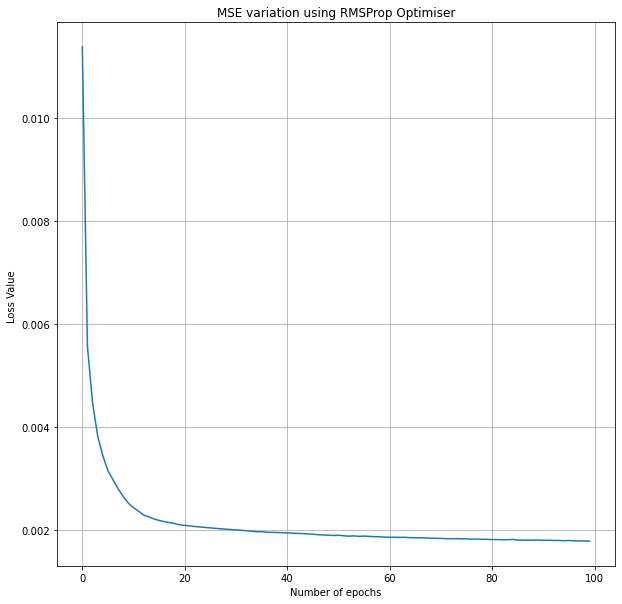

In [54]:
plt.figure(figsize =(10,10))
plt.plot(range(len(lsv)),lsv)
plt.xlabel("Number of epochs")
plt.ylabel("Loss Value ")
plt.title("MSE variation using RMSProp Optimiser")
plt.grid()
plt.savefig("Variation of MSE")

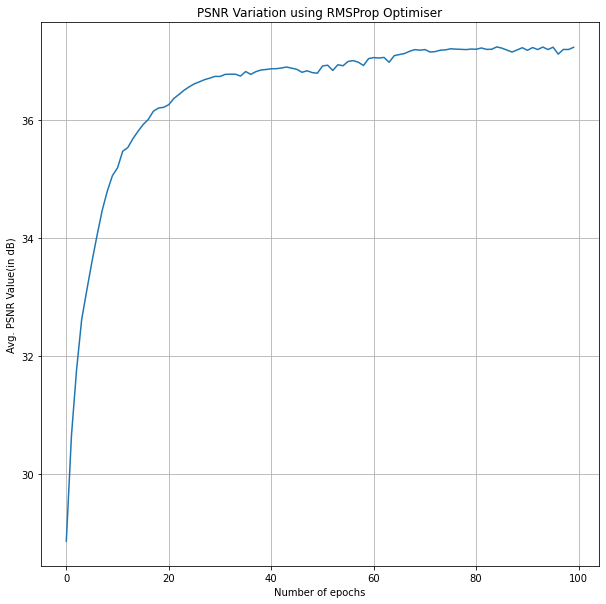

In [53]:
plt.figure(figsize = (10,10))
plt.plot(psnrval)
plt.xlabel("Number of epochs")
plt.ylabel("Avg. PSNR Value(in dB)")
plt.title("PSNR Variation using RMSProp Optimiser")
plt.grid()
plt.savefig("Variation of PSNR using RMSProp Optimiser")


In [71]:
model = 'rmsprop_model_99.pth'
image = 'kyoto-japan-1280x720_4595-mm-90.jpg'
scl = 2

low_res = myTransforms(scl).downscale(Image.open(image))
low_res.save('Low_Res_FSRCNN.bmp')
interpolated_img = myTransforms(scl).BicubicInterpolation(low_res)
interpolated_img.save("Interpolated_FSRCNN.bmp")
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
inp = Image.open(image)

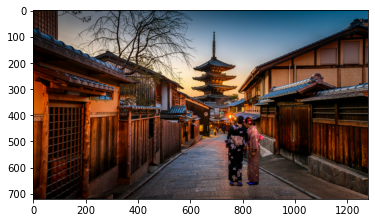

In [72]:
img = Enhance_Image_FSRCNN(model,'Low_Res_FSRCNN.bmp',scl)
img.save('Final_image_FSRCNN.bmp')
plt.imshow(img)

In [73]:
img.size

(1280, 720)